# HW 4
# David Stanko, Aakash Krishna, Josh Wilkes

## Theoretical Background

Understanding the relationship between study habits, health, and other cognitive factors has been a central focus in educational studies. In this project we looked at principal component analysis/SVD, Matrix completion, hierarchical clustering, and K-mean clustering to better understand and visualize these relationships. 

**Principal Component Analysis:** PCA is a dimensionality reduction technique that identifies the directions in which the data varies most, then creates a new data set that is transformed under that new axis. This allows PCA to summarize complex, high-dimensional data into lower level data, aiding in computational efficiency. The principal components are a weighted combination of the original variance that have both scalar and vector properties.

**Singular Value Decomposition:** SVD is a matrix factorization that is very similar to PCA but it decomposes the data of matrix X into three matrices: X = USV. This decomposition allows to understand both the structure, direction, and magnitude of the predictors of the data.

**Matrix Completion:** Real world data often contains missing values. Our dataset also contains some missing data where a student may have forgotten to fill out a question or their response was not able to be determined. Matrix completion is a method for filling in these entries by assuming the data is approximately low-rank (explained by only a few predictors). This ensures that as much information as possible is kept before proceeding to clustering and visualization.

**K-means clustering:** K-means randomly partitions the data in to K-number of groups. And then iteratively selects a center point for each group and then re-assigns the groups to the center point until some threshold is met. This quickly groups the data in a high-level fashion

**Hierarchical Clustering:** Unlike K-means, hierarchical clustering builds a tree dendrogram of clusters without needing to specify the number of groups. This works by initially clustering the data and then merging similar pairs together until they are all groups Different linkage criteria exists such as complete, single, average, and Ward's linkage—determine how distances between clusters are computed. Hierarchical clustering allows us to visualize the structure of different student groups         


**Methodology
A short description of data processing/cleaning, including selection of variables, and a detailed description of how you implemented and tested the models. You should be sure to discuss hyperparameter tuning (what values you tried, how you selected the best), error metrics, comparisons, cross-validation, etc.

Our dataset had some continuous variables, some discrete numerical variables, and some categorical variables. First, we dropped all the categorical variables, because those are hard to interpret in the unsupervised methods we're using. We kept many of the discrete numerical variables. Many of them were integer ratings from 0-5 or 0-10. We kept those because a rating of 1.5, for example, is interpretable. Finally, we scaled the data to have zero mean and unit variance. The preprocessed data matrix had 16 features, including academic performance information, screen time, study habits, and mental health data.

Our models were as follows. First, we performed PCA on the preprocessed data. To see how well PCA approximates the data, we calculated and plotted the percent variance explained (PVE). To determine how many PCA components are needed for a good approximation, we calculated and plotted the cumulative PVE. We used PCA to obtain the importance of the variables, the correlations between them, and other information about the dataset. To quantify these, we looked at the matrix of principal component loadings, 
, and the transformed data, 
, and we made various plots of the original and transformed data.

Matrix completion: To simulate missing data scenarios we pulled 20% of the data at random and then used low-rank matrix approximation using SVD to impute the missing values, we then compared the RMSE to different ranks to determine the optimal one.

K-means: we first found an appropriate number (k) of clusters we would separate our data into on the basis of their silhouette scores. After calculating this value, we performed our K-means function on a sample of our data and found its within-cluster sum of squares, also known as its inertia.

Afterwards, we decided to perform hierarchical clustering on the data. We performed this clustering three separate ways:

Single Linkage, which uses the minimum distance between two points to cluster data.
Complete Linkage, which uses the maximum distance between two points to cluster data.
Average Linkage, which uses the average distance between two points to cluster data.
We then chose our complete linkage model to split into six clusters for a more accurate comparison to our K-means model, which we did by cutting our model tree at the appropriate length.

After comparing our different clusters to themselves and each other to identify common factors, we created a confusion matrix that directly compared our K-means to our hierarchical clustering model and found relatively different results across both methods.

## Imports

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import get_rdataset
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

## Data preprocessing

### Examine the dataset

In [79]:
X = pd.read_csv("enhanced_student_habits_performance_dataset.csv")
X.head()

X_majors = X[['major']]

In [80]:
X.shape

(80000, 31)

In [81]:
is_null = pd.isnull(X) # boolean mask of same size as X for whether each value is null
[sum(is_null[i]) for i in X.columns] # see how many missing values there are in each column

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

The raw data has 80,000 rows and 31 columns. There are no missing values.

In [82]:
dtypes = X.dtypes # examine data types
dtypes

student_id                         int64
age                                int64
gender                            object
major                             object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating             float64
extracurricular_participation     object
previous_gpa                     float64
semester                           int64
stress_level                     float64
dropout_risk                      object
social_activity                    int64
screen_time                      float64
study_environment                 object
access_to_tutoring                object
family_income_ra

We have many categorical variables encoded as strings (e.g.: gender, major, extracurricular_participation), so we have to drop those. However, let's examine all the columns of type `float64`. Some of the `int64` columns might be categorical or unnecessary as well. However, we know any column of type `float64` is continuous numerical data.

In [83]:
categorical_cols = dtypes[dtypes != "float64"].index # get the index of the dtypes series, where the value in the series is not float64
categorical_cols

Index(['student_id', 'age', 'gender', 'major', 'part_time_job', 'diet_quality',
       'exercise_frequency', 'parental_education_level', 'internet_quality',
       'extracurricular_participation', 'semester', 'dropout_risk',
       'social_activity', 'study_environment', 'access_to_tutoring',
       'family_income_range', 'parental_support_level', 'motivation_level',
       'exam_anxiety_score', 'learning_style', 'exam_score'],
      dtype='object')

In [84]:
# Look at the unique values of each non-float column

for col in categorical_cols:
    print(f"\n{'-'*50} {col} {'-'*50}")
    print(f"Unique values: {X[col].unique()}")


-------------------------------------------------- student_id --------------------------------------------------
Unique values: [100000 100001 100002 ... 179997 179998 179999]

-------------------------------------------------- age --------------------------------------------------
Unique values: [26 28 17 27 25 19 16 24 21 22 23 20 18]

-------------------------------------------------- gender --------------------------------------------------
Unique values: ['Male' 'Other' 'Female']

-------------------------------------------------- major --------------------------------------------------
Unique values: ['Computer Science' 'Arts' 'Psychology' 'Business' 'Engineering' 'Biology']

-------------------------------------------------- part_time_job --------------------------------------------------
Unique values: ['Yes' 'No']

-------------------------------------------------- diet_quality --------------------------------------------------
Unique values: ['Poor' 'Good' 'Fair']

---------

Based on context and what the variables represent, we should drop `student_id`, `gender`, `major`, `part_time_job`, `diet_quality`, `parental_education_level`, `internet_quality`, `extracurricular_participation`, `semester`,
                      `dropout_risk`, `study_environment`, `access_to_tutoring`,
                      `family_income_range`, and `learning_style`. We have some variables on a scale of 0-10 or 0-5, like `exercise_frequency` and `social_activity`. Even though those are discrete numerical variables, we think we should keep them because an exercise or social activity frequency of 1.5, for example, is meaningful and interpretable. Ratings like that do not have to be integers.

### Drop categorical variables and other irrelevant variables:

In [85]:
X = X.drop(columns = ["student_id", "gender", "major", "part_time_job",
                      "diet_quality", "exercise_frequency", "parental_education_level",
                      "internet_quality", "extracurricular_participation", "semester",
                      "dropout_risk", "study_environment", "access_to_tutoring",
                      "family_income_range", "learning_style"])

In [86]:
X.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,26,7.645367,3.0,0.1,70.3,6.2,6.0,4.00,5.8,0,10.9,9,7,8,3.0,100
1,28,5.700000,0.5,0.4,88.4,7.2,6.8,4.00,5.8,5,8.3,7,2,10,6.0,99
2,17,2.400000,4.2,0.7,82.1,9.2,5.7,3.79,8.0,5,8.0,3,9,6,7.6,98
3,27,3.400000,4.6,2.3,79.3,4.2,8.5,4.00,4.6,3,11.7,5,3,10,3.2,100
4,25,4.700000,0.8,2.7,62.9,6.5,9.2,4.00,5.7,2,9.4,9,1,10,7.1,98


### Scale the data

We will now scale the data to have zero mean and unit variance.

In [87]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) # scaled dataset
X_scaled.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,1.066790,1.731919,0.344972,-1.641677,0.019161,-0.557064,-0.418464,0.858879,0.403204,-1.467026,0.441221,1.225264,0.527057,-0.283052,-0.959906,0.936783
1,1.600758,0.761237,-1.384614,-1.382158,1.063417,0.124429,-0.002138,0.858879,0.403204,1.466762,-0.493744,0.529203,-1.216462,0.830286,0.192381,0.850512
2,-1.336063,-0.885369,1.175173,-1.122639,0.699947,1.487414,-0.574587,0.405191,1.529583,1.466762,-0.601625,-0.862921,1.224465,-1.396390,0.806934,0.764242
3,1.333774,-0.386398,1.451907,0.261462,0.538405,-1.920049,0.882557,0.858879,-0.211185,0.293247,0.728903,-0.166859,-0.867758,0.830286,-0.883087,0.936783
4,0.799807,0.262265,-1.177064,0.607487,-0.407773,-0.352616,1.246843,0.858879,0.352005,-0.293511,-0.098182,1.225264,-1.565166,0.830286,0.614886,0.764242


## Matrix Completion

First, we will introduce missing elements into the array in order to check the efficacy of the matrix completion later

In [88]:
np.random.seed(21)
X = X_scaled.to_numpy(copy=True)
missing_elements = int(X.shape[0] * 0.2)

row_index = np.random.choice(X.shape[0], size=missing_elements, replace=False)
column_index = np.random.choice(X.shape[1], size=missing_elements)

Xna = X.copy()
Xna[row_index, column_index] = np.nan


In [89]:
def fit_svd(X, M=1):
    U, s, V = np.linalg.svd(X,full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ V[:M, :]) 

Then, we create a function that will return a completed matrix. In this function we initialize variables that will replace the missing values with column means and other variables that will be used to track the progress of the iterations that will be used to fit our data. A while loop is formed that will track and iterate fittings of matrix completions using SVD until the relative error becomes better then the threshold value we created earlier

In [90]:
def matrix_completion(X_na, rank=5, max_iter=100, thresh=1e-7):
    X_filled = X_na.copy()
    
    rel_err = 1
    iter_ = 0
    Xhat = Xna.copy()
    xbar = np.nanmean(Xna, axis=0)
    Xhat[row_index, column_index] = xbar[column_index]
    for r, c in zip(row_index, column_index):
        Xhat[r, c] = xbar[c]




    ismiss = np.isnan(Xna)
    Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
    Xscaled_nomiss = Xscaled[~ismiss]
    mssold = np.mean(np.square(Xscaled_nomiss))
    mss0 = np.mean(np.square(Xna[~ismiss]))

    while rel_err > thresh:
        iter_ += 1
        Xapp = fit_svd(Xhat, M=1)
        Xhat[ismiss] = Xapp[ismiss]
        mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
        rel_err = (mssold - mss) / mss0
        mssold = mss
    
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
   

    return X_filled

Iter: 1, MSS: 0.8381578577434508, Rel. Err: -0.8381940562743331


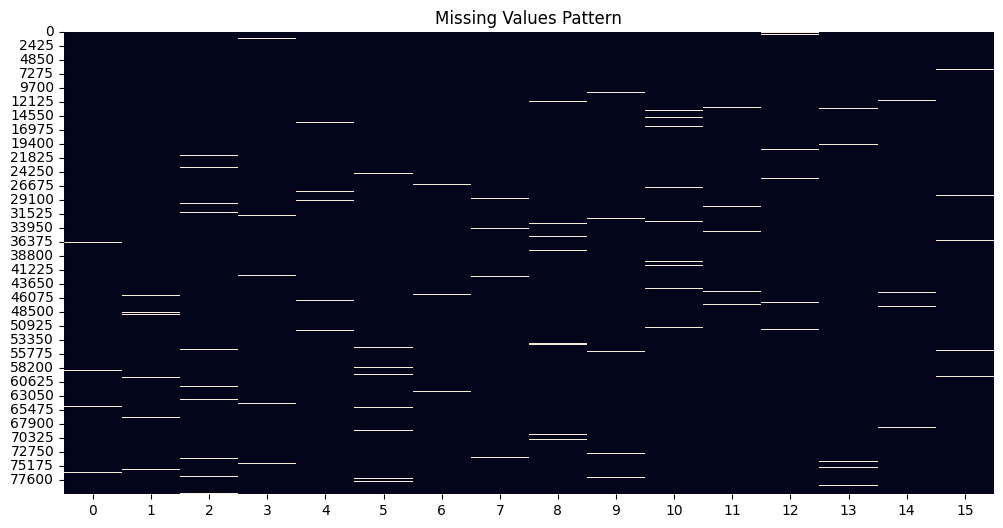

Figure 1: Missing values in data set pre-SVD


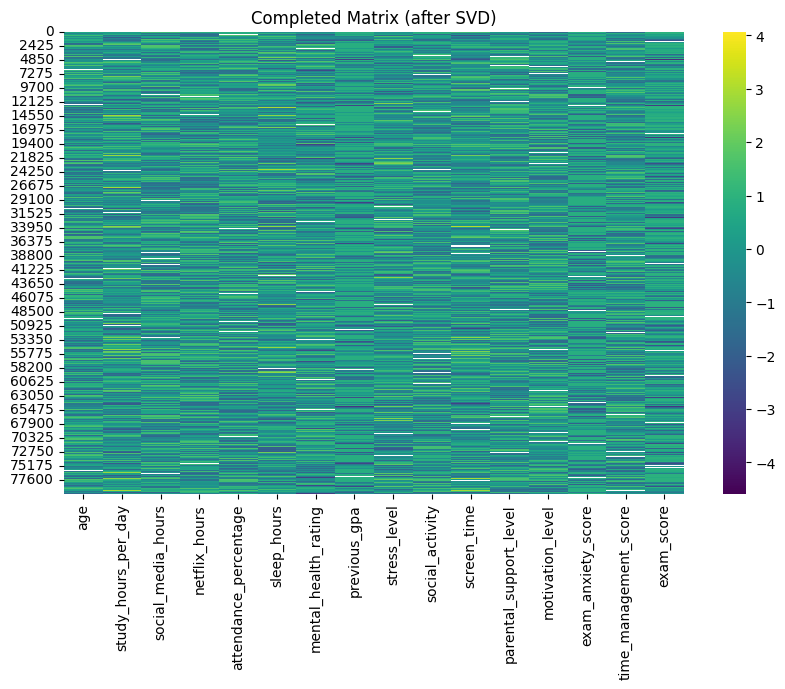

Figure 2: 


In [91]:
X_completed = matrix_completion(Xna, rank=5)

# Convert back to DataFrame for interpretation
X_completed_df = pd.DataFrame(X_completed, columns=X_scaled.columns)

# Compare histograms or heatmaps before and after
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pd.DataFrame(Xna).isna(), cbar=False)
plt.title("Missing Values Pattern")
plt.show()
print("Figure 1: Missing values in data set pre-SVD")

plt.figure(figsize=(10, 6))
sns.heatmap(X_completed_df, cmap="viridis")
plt.title("Completed Matrix (after SVD)")
plt.show()
print("Figure 2: ")


Looking at the distribution of missing values in this code we see even distribution of dropped values in figure 1 and very few to know white values in figure 2 showing the low-level matrix completion was successful. In the next figure we will analyze its performance.

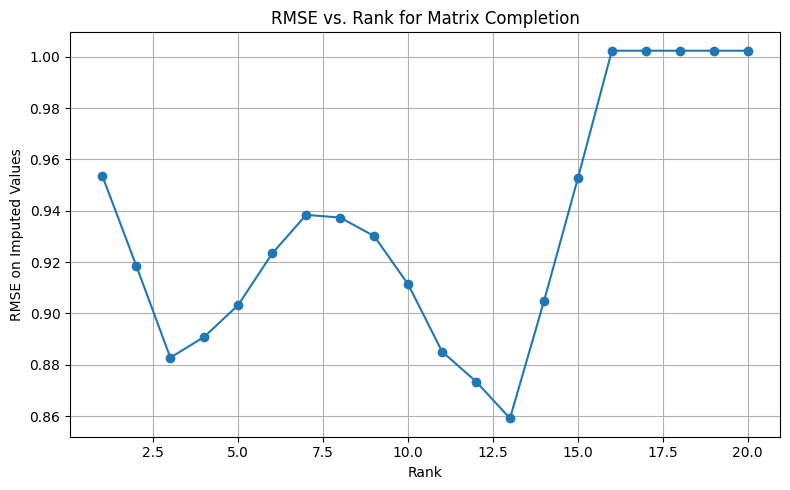

In [92]:
ranks = list(range(1, 21))
rmse_values = []


true_vals = X[row_index, column_index]

for r in ranks:
    Xhat = Xna.copy()
    xbar = np.nanmean(Xna, axis=0)
    for rr, cc in zip(row_index, column_index):
        Xhat[rr, cc] = xbar[cc]

    U, s, Vt = np.linalg.svd(Xhat, full_matrices=False)
    S = np.diag(s[:r])
    Xapp = U[:, :r] @ S @ Vt[:r, :]

    pred_vals = Xapp[row_index, column_index]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    rmse_values.append(rmse)

# Plot RMSE vs Rank
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ranks, rmse_values, marker='o')
plt.title("RMSE vs. Rank for Matrix Completion")
plt.xlabel("Rank")
plt.ylabel("RMSE on Imputed Values")
plt.grid(True)
plt.tight_layout()
plt.show()


When computing the RMSE vs. rank we see that the lowest RMSE is 13. The MSS of this graph was also 0.838157. The RMSE drops quickly at low ranks, suggesting that a very low-rank approximation captures substantial structure in the data. This supports the hypothesis that student behaviors may be governed by a few latent factors. RMSE then fluctuates but reaches its minimum around rank 13. This suggests that 13 components provide the best balance between model complexity and reconstruction accuracy. 

## K-Means

Our first goal is to find the best number of clusters for us to use. We will determine the best number using a short loop that looks at silhouette scores with different numbers of clusters, measuring how clearly defined the clusters are. We will calculate this number, k, as the number of clusters that gives us a low enough silhouette score. We are using a sample of 50 different data points to compare our K-Means and Hierarchical models, as higher numbers make it hard to read our hierarchical models.

In [93]:

np.random.seed(21)
X_samp = X_scaled.sample(n=50)

def compute_k_sil(k):
   kmeansk = KMeans(n_clusters=k, random_state=3, n_init=20).fit(X_samp);
   labels = kmeansk.labels_
   silscore = metrics.silhouette_score(X_samp, labels, metric='euclidean')
   return silscore

kvals = np.arange(2,13)
silvals = [compute_k_sil(kval) for kval in kvals]

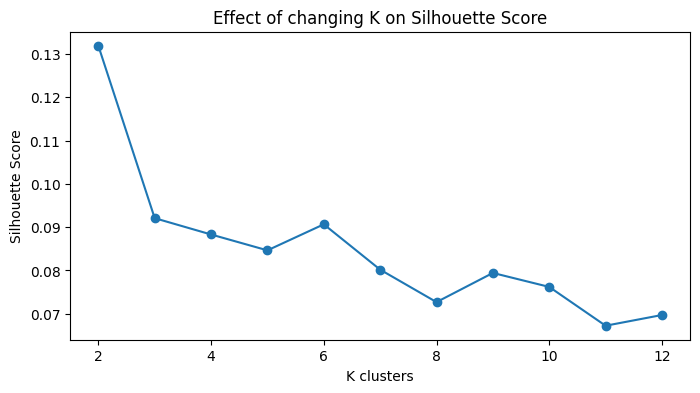

In [94]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(kvals, silvals, linestyle='-', marker='o')
ax.set_xlabel('K clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title("Effect of changing K on Silhouette Score");

From this graph, we can conclude that 6 clusters is a good number to use as it accounts for a majority of the differences between classes and is not too large. After the small spike at 6 clusters, the line graph begins to fall and never quite reaches the same height.

In [95]:
kmeans_s = KMeans(n_clusters=6,
                  random_state=5,
                  n_init=50).fit(X_samp);

kmeans_s.inertia_

490.28485875636164

In [96]:
kmeans_s.labels_

array([4, 5, 3, 0, 3, 4, 3, 1, 4, 1, 0, 2, 3, 3, 1, 1, 1, 1, 4, 5, 4, 2,
       3, 2, 5, 5, 0, 0, 5, 3, 4, 2, 1, 2, 0, 5, 2, 2, 5, 5, 1, 3, 1, 2,
       4, 2, 3, 3, 4, 1])

After running our KMeans model on the observed best number of clusters, we observe a within-cluster sum of squares of roughly 490.28.

### Specific criteria 4 (part 1)

Question: Plot/Discussion: After clustering, which observations belong to the same cluster? Look at the underlying data and see what might be similar between them, and how these differ from observations in other clusters. How can the groups be interpreted?

We will answer this question for K-means clustering now, and later, we will answer it for hierarchical clustering.

In [ ]:
plt.scatter(X_samp["exam_anxiety_score"], X_samp["previous_gpa"], c=kmeans_s.labels_, cmap="rainbow", alpha=0.5)
plt.xlabel("Exam Anxiety Score")
plt.ylabel("GPA")
plt.title("GPA vs. Exam Anxiety Score")
plt.show()

In [ ]:
plt.scatter(X_samp["exam_score"], X_samp["previous_gpa"], c=kmeans_s.labels_, alpha=0.9, cmap="rainbow")
plt.xlabel("Exam Score")
plt.ylabel("GPA")
plt.title("GPA vs. Exam Score")
plt.show()

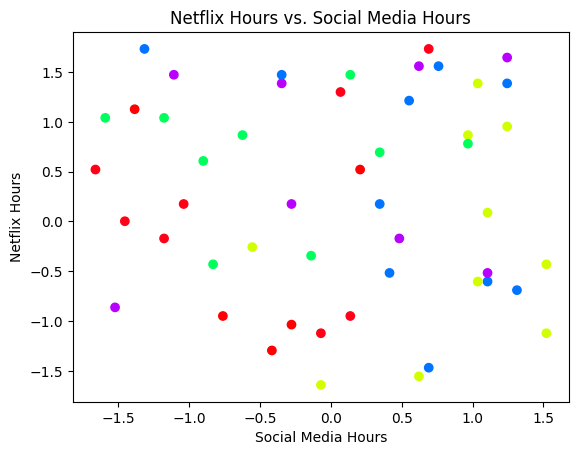

In [99]:
plt.scatter(X_samp["social_media_hours"], X_samp["netflix_hours"], c=kmeans_s.labels_, cmap="hsv")
plt.xlabel("Social Media Hours")
plt.ylabel("Netflix Hours")
plt.title("Netflix Hours vs. Social Media Hours")
plt.show()

In all the plots, the clusters are not very well-defined because far-away points are in the same cluster. That suggests this dataset is not very well-suited for K-means clustering. 

However, let's interpret the clusters that are fairly well-defined. In the GPA vs. exam anxiety score plot, the blue cluster contains students with a below-average exam anxiety score and a wide range of GPAs. The GPAs range from more than 0.5 standard deviations (SDs) above the mean to nearly 1 SD below the mean. So, students with a low exam anxiety score can have a wide range of GPAs, suggesting that exam anxiety score doesn't affect GPA. The red cluster contains students with a below-average exam anxiety score and a high GPA, suggesting that students who are less anxious in exams perform better in school. The green and turquoise clusters have students with a high exam anxiety score and a wide range of GPAs. Overall, we can say that exam anxiety and GPA are unrelated. That is promising because it shows that exam anxiety doesn't cause students to perform badly. If a student can't get help for their exam anxiety, it will not unfairly affect their academic performance.

In the GPA vs. exam score plot, the clusters are all over the place and not defined at all. That suggests no relationship between GPA and exam score. But there clearly is a relationship: as we saw previously, the correlation coefficient between the two features is about 0.93. That suggests k-means clustering is inaccurate for those two features.

In the Netflix hours vs. social media hours plot, the red cluster usually contains students with fewer social media hours, but some students have fewer Netflix hours and others have more Netflix hours. In the yellow-green cluster, most students have more social media hours but a wide range of Netflix hours, from low to high. In the green cluster, students have more Netflix hours but a wide range of social media hours. So, there's no relationship between Netflix use and social media use. 

## Hierarchical Clustering

In [100]:
def plot_hc(linkage, ax, cut=-np.inf):
    cargs = {'above_threshold_color':'black',
             'color_threshold':cut}
    hc = AgglomerativeClustering(n_clusters=None,
                distance_threshold=0,
                linkage=linkage.lower()).fit(X_samp)
    linkage_ = compute_linkage(hc)
    dendrogram(linkage_,
               ax=ax,
               leaf_font_size=10,
               **cargs)
    ax.set_title('%s Linkage' % linkage)
    labs = cut_tree(linkage_, n_clusters=6).reshape(-1)
    return labs

### Specific criteria 4 (part 2)

Question: Plot/Discussion: After clustering, which observations belong to the same cluster? Look at the underlying data and see what might be similar between them, and how these differ from observations in other clusters. How can the groups be interpreted?

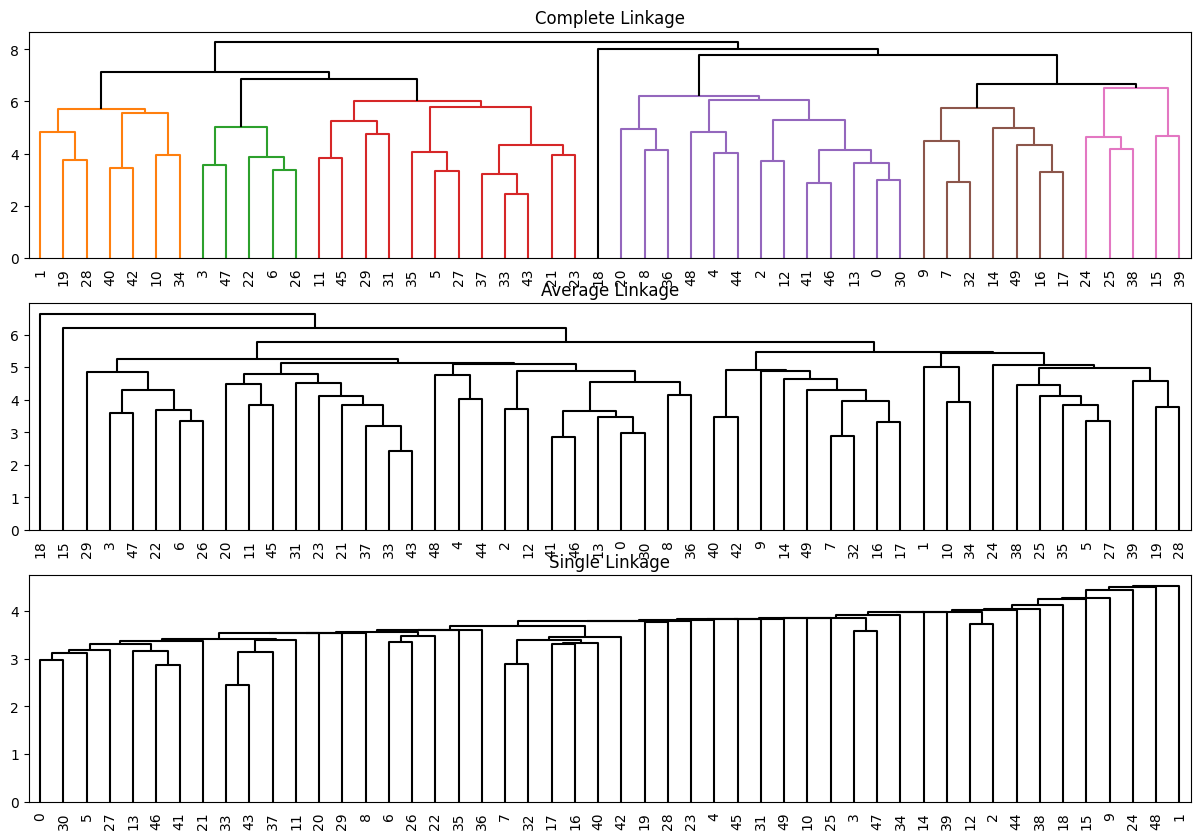

In [101]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
ax = axes[0]; hc_comp = plot_hc('Complete', ax, 6.6)
ax = axes[1]; hc_avg = plot_hc('Average', ax)
ax = axes[2]; hc_sing = plot_hc('Single', ax)

In order to look at similarities in our clusters, let's look at all the samples in the cluster highlighted in red.

In [102]:
X_samp.iloc[[11, 45, 29, 31, 35, 5, 27, 37, 33, 43, 21, 23]]

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
31266,1.600758,-0.585986,-0.139312,-0.344082,-0.575084,0.874070,-0.106219,-1.063896,0.761597,1.466762,-0.313943,0.529203,-1.216462,0.830286,1.651945,-1.047442
60684,1.600758,1.210311,0.344972,0.693994,0.099932,-0.557064,-0.470505,-1.366355,0.863995,0.293247,1.268306,-0.514890,0.178353,0.273617,1.267849,-1.133713
68613,0.265839,-0.136912,1.244357,1.386044,-0.661625,-0.557064,-2.135812,0.686045,-0.467180,-0.293511,0.836784,1.573295,-1.565166,0.830286,1.037392,0.936783
17657,1.333774,0.742592,-1.592164,1.040019,-1.348180,-0.148168,0.622353,0.858879,-1.491161,-0.880268,-0.026261,0.877233,-0.519054,0.830286,1.459897,0.505430
10857,1.333774,0.262265,0.690889,1.732070,-1.117405,-0.761512,0.310108,0.599628,0.198408,0.880004,1.340226,1.573295,0.875761,-0.839721,-0.230124,0.936783
66114,0.265839,-0.153694,-0.346862,1.386044,0.463403,0.533324,1.663170,0.858879,0.352005,0.880004,0.477182,1.573295,0.178353,0.273617,-1.612869,0.936783
57586,-0.268128,-1.134855,0.206605,0.520981,0.076855,-0.148168,0.414189,0.275565,-0.569578,1.466762,-0.242023,1.573295,-0.170351,0.830286,0.230791,0.074076
29554,0.532823,0.262265,-0.623596,0.867006,-0.984710,-0.284467,0.153985,0.858879,0.812796,1.466762,0.189500,0.181172,-1.565166,0.830286,1.383078,0.419159
68860,0.532823,-0.087015,0.967623,0.780500,0.365323,0.465175,0.726434,0.621233,0.096010,0.880004,0.836784,-1.558982,-1.216462,0.830286,0.960573,0.936783
2775,-0.268128,0.312162,-0.900330,0.607487,0.544174,0.397026,1.350925,0.513212,0.608000,0.293247,0.189500,-1.558982,-1.565166,0.830286,0.960573,0.764242


Just by looking at the table, we can immediately observe similarities between values in multiple rows. For example, the first two rows have the exact same scaled age value. Rows 2 and 3 have the same sleep_hours score, and rows 4, 6, and 8 all have the same scaled previous_gpa score. Most rows also display the exact same exam_anxiety score, and even two of the outlier rows have the same score as each other. The biggest factor uniting these samples is the shared exam_anxiety score, but in general, they all share common scores across other categories as well, which is most likely why they are grouped together. Now let's look at the cluster highlighted in pink and see what is in common.

In [103]:
X_samp.iloc[[24, 25, 38, 15, 39]]

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
11297,1.066790,1.013412,-1.177064,-0.171070,0.134548,-0.420765,0.049903,0.858879,0.352005,1.466762,-0.026261,-1.210952,1.573168,-1.953059,1.613535,0.936783
10934,1.066790,0.012780,0.068238,1.299538,1.588430,0.601473,0.206026,0.858879,-1.593559,1.466762,0.441221,0.181172,1.224465,-1.396390,-0.767858,0.764242
39029,0.265839,2.377229,-1.661348,0.520981,0.699947,0.397026,1.663170,0.794066,-0.774374,1.466762,1.340226,1.573295,0.875761,-0.839721,0.192381,0.936783
74413,-0.001145,3.489541,0.621706,-1.555171,-0.332771,-0.011870,-0.262342,0.858879,-0.159985,-1.467026,2.023470,1.573295,0.875761,-0.839721,0.307610,0.677971
17650,0.532823,1.643978,-0.070129,-1.122639,-1.180869,0.260727,0.622353,0.858879,-2.054350,-0.293511,0.836784,-0.862921,0.527057,-0.283052,-1.497640,0.936783


This group shares similar social_activity and exam_score levels. We also observe that four of five rows share the same previous_gpa score. Overall, this group shows less social media and netflix hours than the red group. This group also reports higher motivation levels and lower exam anxiety. Although a lot of the common rows have values shared across the red cluster as well, the overall patterns of these groups seem to be different.

Below is a confusion matrix comparing K-means classification to hierarchical classification.

In [104]:
pd.crosstab(pd.Series(hc_comp, name='HClust'),
            pd.Series(kmeans_s.labels_, name='K-means'))

K-means,0,1,2,3,4,5
HClust,,,,,,
0,0,0,1,6,6,0
1,2,2,0,0,0,3
2,2,0,0,3,0,0
3,1,0,8,1,1,1
4,0,8,0,0,0,4
5,0,0,0,0,1,0


Our confusion matrix shows us that our K-means and hierarchical methods have somewhat dissimilar ideas for clustering, as most classes in our hierarchical classifications are divided into two or three different classifications on the K-means methods (with the exception of hierarchical group 5, which only has one instance). If we wanted to look at explicit matches, only 3 out of 50 samples had the same class number across both classification methods.

**Conclusion

When looking at k-means clustering we saw poor clustering that was probably caused from many point being equally far spaced apart from one another suggesting this is a poor candidate for k-means. The findings that we did see that students who had varying levels of exam anxiety did not have any impact on their chances for academic success, interestilingly, we also saw very limited results when comparing exam scoring with academic success as well.  
In all the plots, the clusters are not very well-defined because far-away points are in the same cluster. That suggests this dataset is not very well-suited for K-means clustering.

When looking at hierarchical clustering we saw groupings of social activity and exam score, as well as social media and netflix hours, and finally, exam anxiety and exam score were also grouped together. and interpretation of this is that people who report higher levels of social activity also perform better on exams indicating perhaps forming study groups are promoting pro-social behavior with other people help with consistent study habits. social media and netflix hours were also correlated indicating that people tend to spend roughly the same amount of 'down-time' performing similar amounts of activities, but these do not seem to contribute to academic success. Finally exam anxiety and exam performance were also correlated indicating the connection between how people feel about an exam and their performance on it. One group in particular denoted as the "red group" in clustering is particularly of note. this group had a positive corelation of hours studied, previous gpa, reported anxiety, social activity, and motivation levels with a negative component of social media and netflix, indicating that a person who has one or more of these a positive correlation groups are more likely to have the other and will also predict academic success

